In [0]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from datetime import datetime
import math
from sklearn.model_selection import train_test_split
%matplotlib inline


In [0]:
df = pd.read_csv("/dbfs/FileStore/shared_uploads/chien.liu@hellofresh.com/within_covid.csv", parse_dates=['ds'])
df_covid = pd.read_csv("/dbfs/FileStore/shared_uploads/chien.liu@hellofresh.com/Covid.csv")

#Define Setting

In [0]:
df_input = df[['ds', 'simulated']]
df_input = df_input.rename(columns = {'simulated' : 'activations'})
df_input['ds'] =  pd.to_datetime(df_input['ds'])
df_input_index = df_input.set_index(['ds'])
df_input.head()

,ds,activations
0,2018-01-07 00:00:00+00:00,4893.0
1,2018-01-14 00:00:00+00:00,4695.0
2,2018-01-21 00:00:00+00:00,4510.0
3,2018-01-28 00:00:00+00:00,4760.0
4,2018-02-04 00:00:00+00:00,4467.0


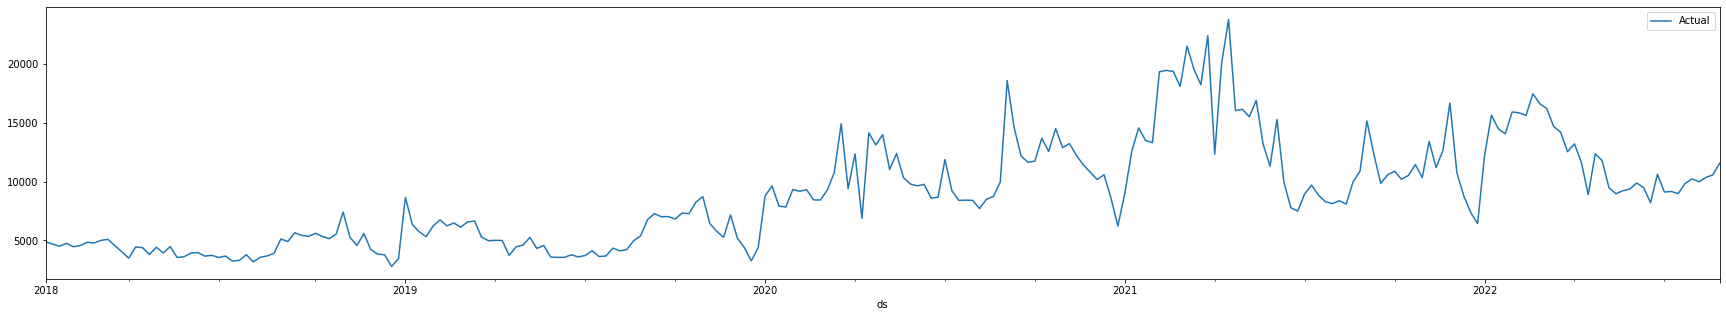

In [0]:
f, ax = plt.subplots(figsize=(30, 5))

df_input.plot(kind='line',x='ds', y='activations', label='Actual', ax=ax)
plt.legend()
plt.show()

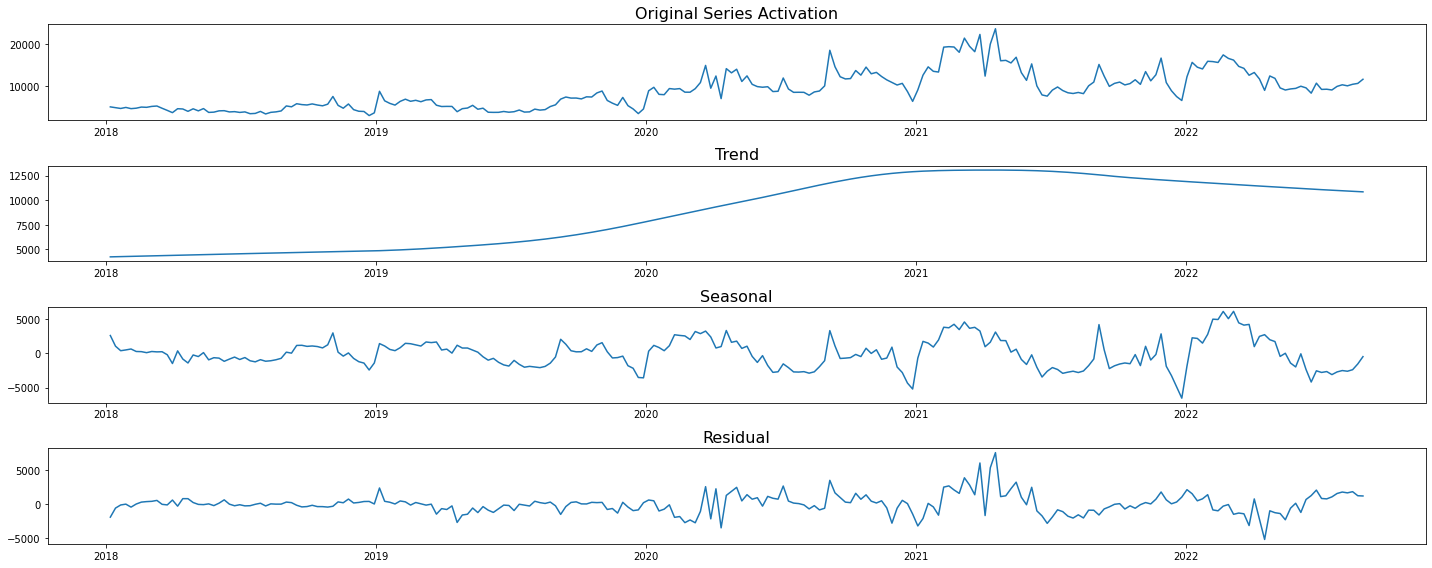

In [0]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL

stl_conversions = STL(df_input.set_index(['ds']))
result_conversions = stl_conversions.fit()

seasonal_conversions, trend_conversions, resid_conversions = result_conversions.seasonal, result_conversions.trend, result_conversions.resid

plt.figure(figsize=(20,8))


plt.subplot(4,1,1)
plt.plot(df_input.set_index(['ds']))
plt.title('Original Series Activation', fontsize=16)

plt.subplot(4,1,2)
plt.plot(trend_conversions)
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(seasonal_conversions)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(resid_conversions)
plt.title('Residual', fontsize=16)

plt.tight_layout()

#Train and Test Split

In [0]:
train_df = df_input.iloc[:int(len(df_input)*0.8)]
train_df_index = train_df.set_index(['ds'])
test_df = df_input.iloc[int(len(df_input)*0.8):]
test_df_index = test_df.set_index(['ds'])

print('train:', len(train_df), ' test:', len(test_df), ' total:', len(df_input))

## train_df >> 01.03 to 27.07
## train_df >> 28.07 to 30.09

train: 194  test: 49  total: 243


#Weekly

##Train

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


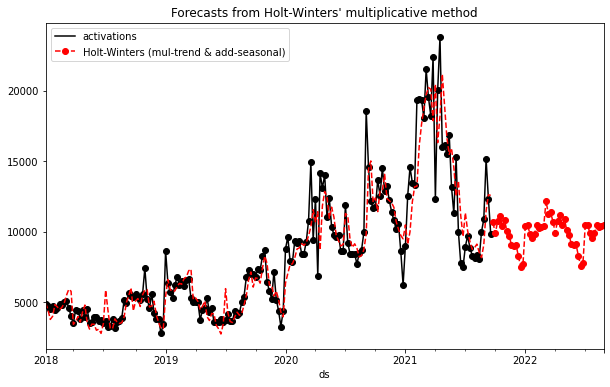

,Additive Dam
alpha,4.646429e-01
beta,1.000000e-04
phi,9.900000e-01
gamma,1.019728e-01
l0,4.273901e+03
b0,1.001099e+00
SSE,6.441125e+08


In [0]:
fit3 = ExponentialSmoothing(
    train_df_index,
    seasonal_periods=26,
    trend="mul",
    seasonal="add",
    damped_trend=True,
    # initial_level = 3,
    # initial_trend = 7,
    # initial_seasonal= 5,
    initialization_method="estimated",
    freq = 'W',
).fit()


results = pd.DataFrame(
    index=['alpha', 'beta', 'phi', 'gamma', 'l0', 'b0', 'SSE']
)

params = [
    "smoothing_level",
    "smoothing_trend",
    "damping_trend",
    "smoothing_seasonal",
    "initial_level",
    "initial_trend",
]

results["Additive Dam"] = [fit3.params[p] for p in params] + [fit3.sse]

ax = train_df_index.plot(
    figsize=(10, 6),
    marker="o",
    color="black",
    title="Forecasts from Holt-Winters' multiplicative method",
)

fit3.fittedvalues.plot(ax=ax, style="--", color="red")

fit3.forecast(len(test_df)).rename("Holt-Winters (mul-trend & add-seasonal)").plot(
    ax=ax, style="--", marker="o", color="red", legend=True
)

plt.show()
results

In [0]:
fit3_df = fit3.fittedvalues.to_frame()
fit3_df_columns = ['activations']
fit3_df.columns = fit3_df_columns
fit3_df.head()

,activations
ds,
2018-01-07 00:00:00+00:00,4933.762216
2018-01-14 00:00:00+00:00,4455.381185
2018-01-21 00:00:00+00:00,3779.165139
2018-01-28 00:00:00+00:00,3998.010095
2018-02-04 00:00:00+00:00,4827.569953


In [0]:
##historical forecast

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

##original values evaluation

print('R-aquared: ' + str(r2_score(train_df_index, fit3_df)))
print('MAPE: ' + str(mean_absolute_percentage_error(train_df_index, fit3_df)))
print('RMSE', mean_squared_error(train_df_index, fit3_df, squared=False))

R-aquared: 0.8348546948236756
MAPE: 0.13588635836966836
RMSE 1822.1327416281833


##Test

In [0]:
forecast_test= fit3.forecast(len(test_df)).to_frame()
forecast_test = forecast_test.reset_index()
forecast_test.columns = ['ds', 'forecasted_activations']
forecast_test_index = forecast_test.set_index(['ds'])
forecast_test_index.tail()

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


,forecasted_activations
ds,
2022-07-31 00:00:00+00:00,9889.524587
2022-08-07 00:00:00+00:00,10493.839826
2022-08-14 00:00:00+00:00,10307.005169
2022-08-21 00:00:00+00:00,10376.115801
2022-08-28 00:00:00+00:00,10461.928439


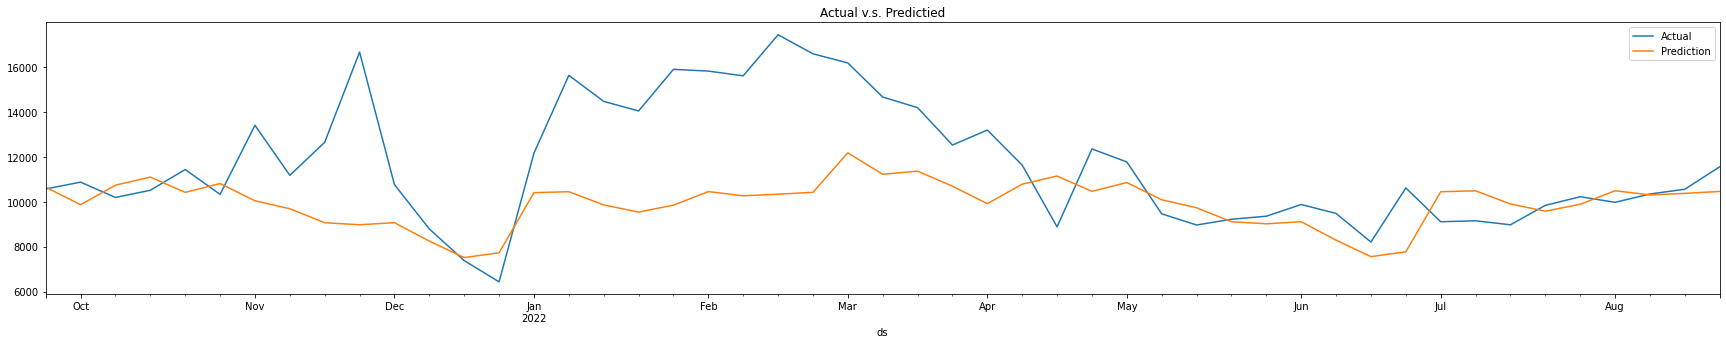

In [0]:
f, ax = plt.subplots(figsize=(30, 5))

test_df.plot(kind='line',x='ds', y='activations', label='Actual', ax=ax)
forecast_test.plot(kind='line',x='ds', y='forecasted_activations', label='Prediction', ax=ax)
plt.title('Actual v.s. Predictied')
plt.legend()
plt.show()

In [0]:
##test forecast

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

##original values evaluation

print('R-aquared: ', str(r2_score(test_df_index, forecast_test_index)))
print('MAPE: ' , str(mean_absolute_percentage_error(test_df_index, forecast_test_index)))
print('RMSE', mean_squared_error(test_df_index, forecast_test_index, squared=False))

R-aquared:  -0.20841021040233154
MAPE:  0.16080992392930513
RMSE 2947.5651780073003


##Forecast

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


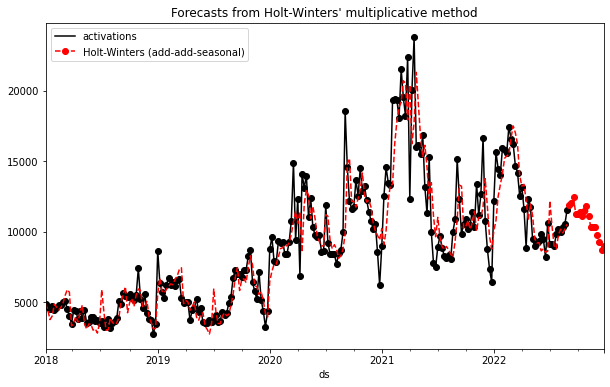

,Additive Dam
alpha,5.000000e-01
beta,1.000000e-04
phi,9.900000e-01
gamma,2.500000e-02
l0,4.273901e+03
b0,1.001099e+00
SSE,8.130076e+08


In [0]:
fit3 = ExponentialSmoothing(
    df_input_index,
    seasonal_periods=26,
    trend="mul",
    seasonal="add",
    damped_trend=True,
    # initial_level = 3,
    # initial_trend = 7,
    # initial_seasonal= 5,
    initialization_method="estimated",
    freq = 'W',
).fit()


results = pd.DataFrame(
    index=['alpha', 'beta', 'phi', 'gamma', 'l0', 'b0', 'SSE']
)

params = [
    "smoothing_level",
    "smoothing_trend",
    "damping_trend",
    "smoothing_seasonal",
    "initial_level",
    "initial_trend",
]

results["Additive Dam"] = [fit3.params[p] for p in params] + [fit3.sse]

ax = df_input_index.plot(
    figsize=(10, 6),
    marker="o",
    color="black",
    title="Forecasts from Holt-Winters' multiplicative method",
)

fit3.fittedvalues.plot(ax=ax, style="--", color="red")

fit3.forecast(17).rename("Holt-Winters (add-add-seasonal)").plot(
    ax=ax, style="--", marker="o", color="red", legend=True
)

plt.show()
results

In [0]:
forecast_test_weekly= fit3.forecast(17).to_frame()
forecast_test_weekly = forecast_test_weekly.reset_index()
forecast_test_weekly.columns = ['ds', 'forecasted_activations']
forecast_test_index_weekly = forecast_test_weekly.set_index(['ds'])
forecast_test_index_weekly.tail()

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


,forecasted_activations
ds,
2022-11-27 00:00:00+00:00,10369.256205
2022-12-04 00:00:00+00:00,9762.992986
2022-12-11 00:00:00+00:00,9293.149708
2022-12-18 00:00:00+00:00,8693.334055
2022-12-25 00:00:00+00:00,9006.868046


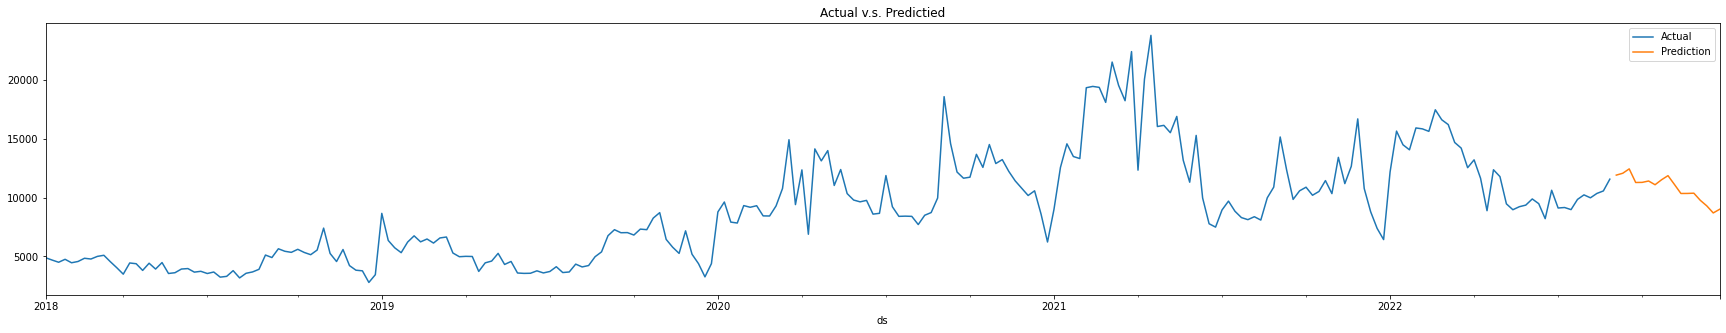

In [0]:
f, ax = plt.subplots(figsize=(30, 5))

df_input_index.plot(kind='line',y='activations', label='Actual', ax=ax)
forecast_test_index_weekly.plot(kind='line',y='forecasted_activations', label='Prediction', ax=ax)
plt.title('Actual v.s. Predictied')
plt.legend()
plt.show()

##Weekly do

In [0]:
future_real = pd.read_csv("/dbfs/FileStore/shared_uploads/chien.liu@hellofresh.com/W_input.csv", parse_dates=['ds'])
future_real = future_real[['ds', 'simulated']]
future_real.head()

,ds,simulated
0,2022-08-07 00:00:00+00:00,9530
1,2022-08-14 00:00:00+00:00,9602
2,2022-08-21 00:00:00+00:00,10011
3,2022-08-28 00:00:00+00:00,10759
4,2022-09-04 00:00:00+00:00,13129


In [0]:
future_real = future_real[future_real['ds'] > '2022-09-01']
# future_real_df = future_real_df[['ds', '']]
future_real_df_index = future_real.set_index(['ds'])
future_real_df_index

,simulated
ds,
2022-09-04 00:00:00+00:00,13129
2022-09-11 00:00:00+00:00,13101
2022-09-18 00:00:00+00:00,11780
2022-09-25 00:00:00+00:00,10800
2022-10-02 00:00:00+00:00,10426
2022-10-09 00:00:00+00:00,11367
2022-10-16 00:00:00+00:00,11168
2022-10-23 00:00:00+00:00,11180
2022-10-30 00:00:00+00:00,11349


In [0]:
forecast_df = forecast_test_weekly[forecast_test_weekly['ds'] > '2022-09-01']
forecast_df = forecast_test_weekly[forecast_test_weekly['ds'] < '2022-11-27'].set_index(['ds'])
forecast_df

,forecasted_activations
ds,
2022-09-04 00:00:00+00:00,11902.308873
2022-09-11 00:00:00+00:00,12059.723510
2022-09-18 00:00:00+00:00,12430.722071
2022-09-25 00:00:00+00:00,11277.161753
2022-10-02 00:00:00+00:00,11285.754279
2022-10-09 00:00:00+00:00,11402.646495
2022-10-16 00:00:00+00:00,11086.512457
2022-10-23 00:00:00+00:00,11506.035884
2022-10-30 00:00:00+00:00,11856.858437


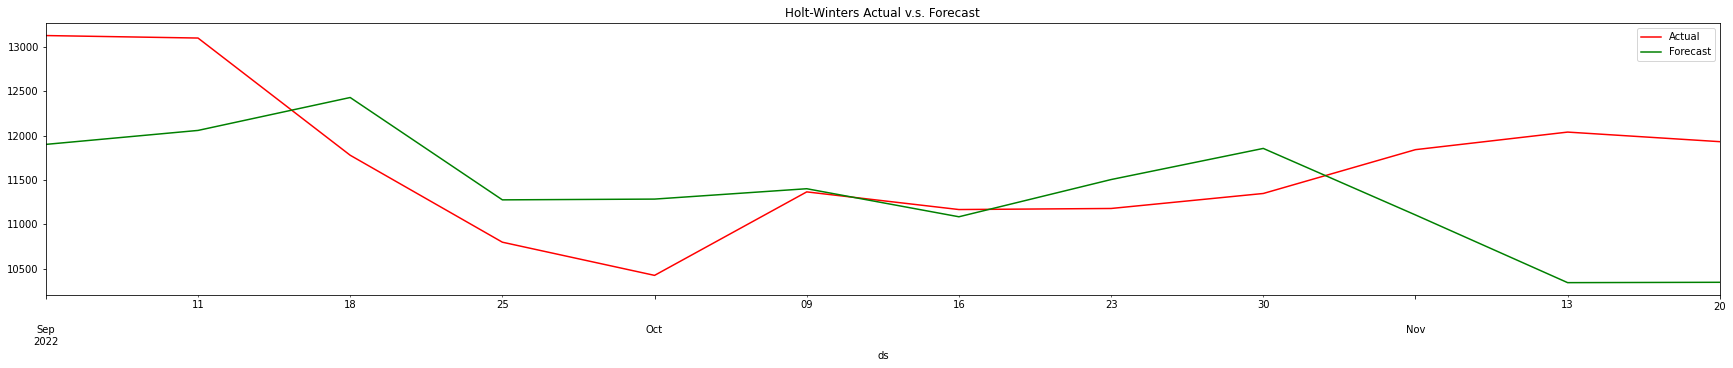

In [0]:
f, ax = plt.subplots(figsize=(30, 5))

future_real_df_index.plot(kind='line',y='simulated', color='red', label='Actual', ax=ax)
forecast_df.plot(kind='line',y='forecasted_activations', color='green',label='Forecast', ax=ax)
plt.title('Holt-Winters Actual v.s. Forecast')
plt.legend()
plt.show()

In [0]:
from sklearn.metrics import mean_absolute_percentage_error,  r2_score, mean_squared_error

y_true = future_real_df_index
y_pred = forecast_df

print('mape:', mean_absolute_percentage_error(y_true, y_pred))
print('r2:', r2_score(y_true, y_pred))
print('RMSE', mean_squared_error(y_true, y_pred, squared=False))

mape: 0.06458604402562206
r2: -0.38680320564192816
RMSE 925.7779576137126


In [0]:
#Monthly 

In [0]:
df_input = df[['ds', 'simulated']]
df_input = df_input.rename(columns = {'simulated' : 'activations'})
df_input['ds'] =  pd.to_datetime(df_input['ds'])
df_input_index = df_input.set_index(['ds'])
df_input_montly = df_input_index.resample('M').sum()
df_input_montly.head()

,activations
ds,
2018-01-31 00:00:00+00:00,18858.0
2018-02-28 00:00:00+00:00,18675.0
2018-03-31 00:00:00+00:00,18711.0
2018-04-30 00:00:00+00:00,20580.0
2018-05-31 00:00:00+00:00,15596.0


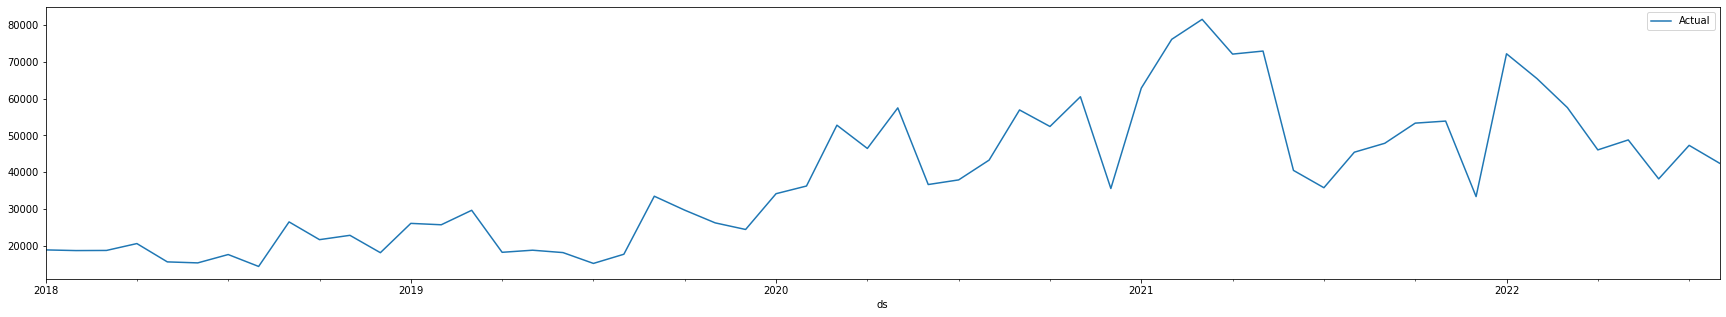

In [0]:
f, ax = plt.subplots(figsize=(30, 5))

df_input_montly.plot(kind='line',y='activations', label='Actual', ax=ax)
plt.legend()
plt.show()

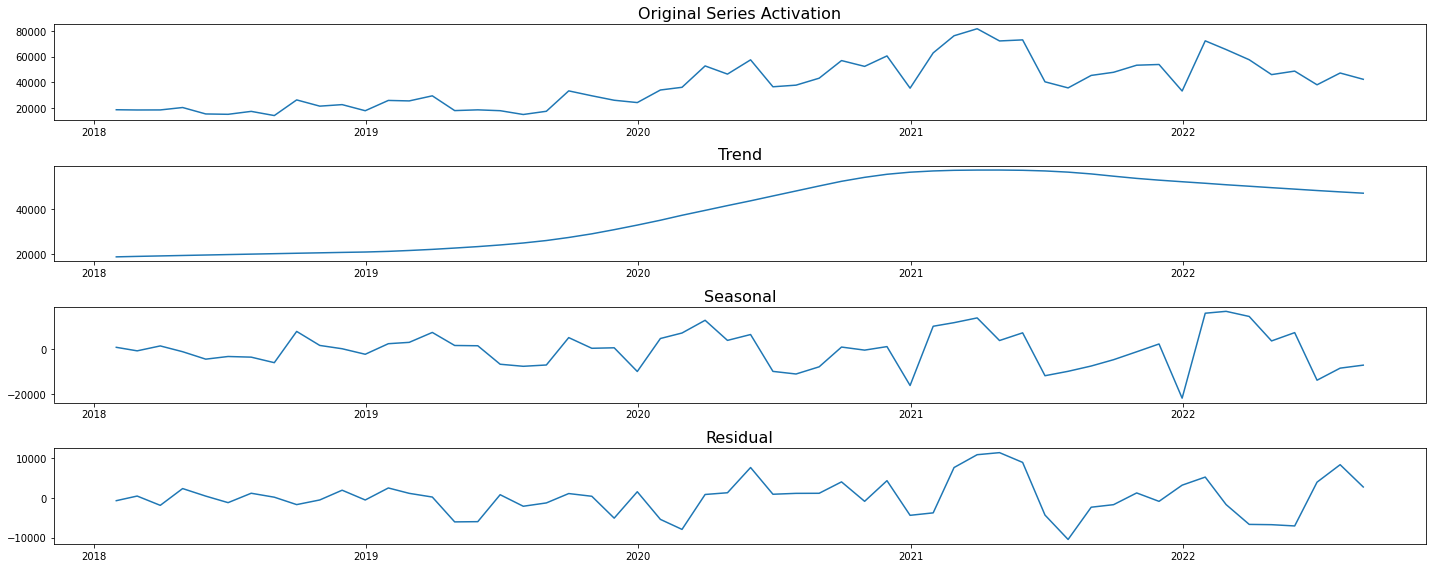

In [0]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL

stl_conversions = STL(df_input_montly)
result_conversions = stl_conversions.fit()

seasonal_conversions, trend_conversions, resid_conversions = result_conversions.seasonal, result_conversions.trend, result_conversions.resid

plt.figure(figsize=(20,8))


plt.subplot(4,1,1)
plt.plot(df_input_montly)
plt.title('Original Series Activation', fontsize=16)

plt.subplot(4,1,2)
plt.plot(trend_conversions)
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(seasonal_conversions)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(resid_conversions)
plt.title('Residual', fontsize=16)

plt.tight_layout()

In [0]:
train_df_monthly = df_input_montly.iloc[:int(len(df_input_montly)*0.8)]
test_df_monthly = df_input_montly.iloc[int(len(df_input_montly)*0.8):]

print('train:', len(train_df_monthly), ' test:', len(test_df_monthly), ' total:', len(df_input_montly))

## train_df >> 01.03 to 27.07
## train_df >> 28.07 to 30.09

train: 44  test: 12  total: 56


In [0]:
<!-- %md ##Train -->

In [0]:
# fit3 = ExponentialSmoothing(
#     train_df_monthly,
#     seasonal_periods=12,
#     trend="add",
#     seasonal="add",
#     damped_trend=0.9,
#     # initial_level = 3,
#     # initial_trend = 7,
#     # initial_seasonal= 5,
#     initialization_method="estimated",
#     freq = 'M',
# ).fit()


# results = pd.DataFrame(
#     index=['alpha', 'beta', 'phi', 'gamma', 'l0', 'b0', 'SSE']
# )

# params = [
#     "smoothing_level",
#     "smoothing_trend",
#     "damping_trend",
#     "smoothing_seasonal",
#     "initial_level",
#     "initial_trend",
# ]

# results["Additive Dam"] = [fit3.params[p] for p in params] + [fit3.sse]

# ax = train_df_monthly.plot(
#     figsize=(10, 6),
#     marker="o",
#     color="black",
#     title="Forecasts from Holt-Winters' multiplicative method",
# )

# fit3.fittedvalues.plot(ax=ax, style="--", color="red")

# fit3.forecast(len(test_df)).rename("Holt-Winters (add-add-seasonal)").plot(
#     ax=ax, style="--", marker="o", color="red", legend=True
# )

# plt.show()
# results

In [0]:
# fit3_df = fit3.fittedvalues.to_frame()
# fit3_df_columns = ['activations']
# fit3_df.columns = fit3_df_columns
# fit3_df.head()

In [0]:
# ##historical forecast

# from sklearn.metrics import r2_score
# from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

# ##original values evaluation

# print('R-aquared: ' + str(r2_score(train_df_monthly, fit3_df)))
# print('MAPE: ' + str(mean_absolute_percentage_error(train_df_monthly, fit3_df)))
# print('RMSE', mean_squared_error(train_df_monthly, fit3_df, squared=False))

In [0]:
<!-- %md ##Test -->

In [0]:
# forecast_test= fit3.forecast(len(test_df_monthly)).to_frame()
# forecast_test = forecast_test.reset_index()
# forecast_test.columns = ['ds', 'forecasted_activations']
# forecast_test_index = forecast_test.set_index(['ds'])
# forecast_test_index.tail()

In [0]:
# f, ax = plt.subplots(figsize=(30, 5))

# test_df_monthly.plot(kind='line',y='activations', label='Actual', ax=ax)
# forecast_test_index.plot(kind='line',y='forecasted_activations', label='Prediction', ax=ax)
# plt.title('Actual v.s. Predictied')
# plt.legend()
# plt.show()

In [0]:
# ##test forecast

# from sklearn.metrics import r2_score
# from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

# ##original values evaluation

# print('R-aquared: ', str(r2_score(test_df_monthly, forecast_test_index)))
# print('MAPE: ' , str(mean_absolute_percentage_error(test_df_monthly, forecast_test_index)))
# print('RMSE', mean_squared_error(test_df_monthly, forecast_test_index, squared=False))

In [0]:
<!-- %md ##Forecast -->

In [0]:
# fit3 = ExponentialSmoothing(
#     df_input_montly,
#     seasonal_periods=12,
#     trend="add",
#     seasonal="add",
#     damped_trend=0.9,
#     # initial_level = 3,
#     # initial_trend = 7,
#     # initial_seasonal= 5,
#     initialization_method="estimated",
#     freq = 'M',
# ).fit()


# results = pd.DataFrame(
#     index=['alpha', 'beta', 'phi', 'gamma', 'l0', 'b0', 'SSE']
# )

# params = [
#     "smoothing_level",
#     "smoothing_trend",
#     "damping_trend",
#     "smoothing_seasonal",
#     "initial_level",
#     "initial_trend",
# ]

# results["Additive Dam"] = [fit3.params[p] for p in params] + [fit3.sse]

# ax = train_df_monthly.plot(
#     figsize=(10, 6),
#     marker="o",
#     color="black",
#     title="Forecasts from Holt-Winters' multiplicative method",
# )

# fit3.fittedvalues.plot(ax=ax, style="--", color="red")

# fit3.forecast(len(test_df)).rename("Holt-Winters (add-add-seasonal)").plot(
#     ax=ax, style="--", marker="o", color="red", legend=True
# )

# plt.show()
# results

In [0]:
# forecast_test= fit3.forecast(17).to_frame()
# forecast_test = forecast_test.reset_index()
# forecast_test.columns = ['ds', 'forecasted_activations']
# forecast_test_index = forecast_test.set_index(['ds'])
# forecast_test_index.tail()

In [0]:
# f, ax = plt.subplots(figsize=(30, 5))

# df_input_index.plot(kind='line',y='activations', label='Actual', ax=ax)
# forecast_test_index.plot(kind='line',y='forecasted_activations', label='Prediction', ax=ax)
# plt.title('Actual v.s. Predictied')
# plt.legend()
# plt.show()

In [0]:
<!-- %md ##Month do -->

In [0]:
# future_real = pd.read_csv("/dbfs/FileStore/shared_uploads/chien.liu@hellofresh.com/W_input.csv", parse_dates=['ds'])
# future_real = future_real[['ds', 'simulated']]
# future_real.head()

In [0]:
# future_real = future_real[future_real['ds'] > '2022-09-01']
# # future_real_df = future_real_df[['ds', '']]
# future_real_df_index = future_real.set_index(['ds'])
# future_real_df_index

In [0]:
# forecast_df = forecast_test[forecast_test['ds'] > '2022-09-01']
# forecast_df = forecast_test[forecast_test['ds'] < '2022-11-27'].set_index(['ds'])
# forecast_df